In [87]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
import nltk
import lyricsgenius
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
import pickle
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

## Datasets

In [24]:
df_original = pd.read_pickle("lib/playlists.pkl")
df = df_original.explode("tracks")
df_track = pd.read_pickle("lib/tracks.pkl")
df_track_features = pd.read_csv("lib/tracks_features.csv", index_col=False)

## Spotipy

In [81]:
client_credentials_manager = SpotifyClientCredentials(client_id='4dc960ae9982499187d62cebfa60372f', client_secret='ee92a0f3985e44fa9405354117a64edc')
spotify = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

#Get release dates of each track
release_dates = []
for index, row in df_track.iterrows():
    album = spotify.album(row['album_uri'][14:], market=None)
    release_dates.append(album['release_date'][:4])

## EDA

<AxesSubplot:title={'center':'Trend of music features over time'}, xlabel='Year', ylabel='Value'>

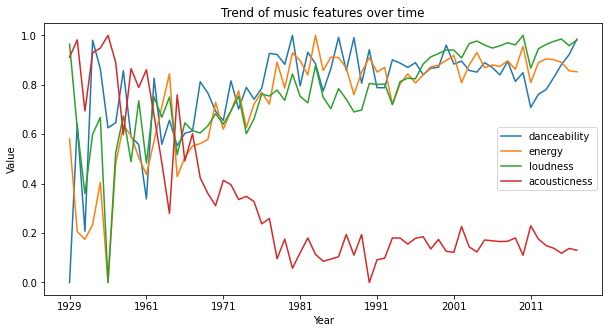

In [93]:
df_track_new = df_track.copy()
df_track_new = df_track_few.assign(release_date=release_dates)
df_merged_vis = pd.merge(df_track_new, df_track_features, on='tid',  how='left')
df_merged_vis = df_merged_vis[['tid', 'release_date', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]
df_merged_means = df_merged_vis.groupby(['release_date']).mean()
df_merged_means = df_merged_means.iloc[1:]
release_dates_index = df_merged_means.index.tolist()
scaler = MinMaxScaler()
df_merged_means = pd.DataFrame(scaler.fit_transform(df_merged_means))
df_merged_means.index = release_dates_index
df_merged_means.columns = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
df_merged_means.plot(y=['danceability', 'energy', 'loudness','acousticness'], kind='line', use_index=True, 
                  figsize=(10,5),
                  title="Trend of music features over time", xlabel='Year', ylabel='Value')

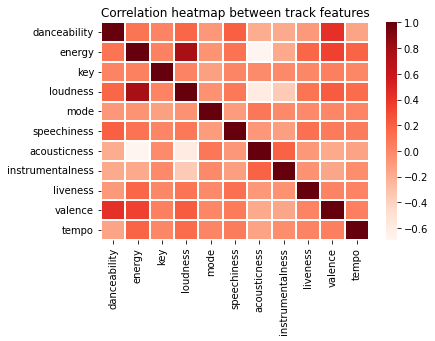

In [92]:
#Compute pairwise correlation
corr = df_track_features.iloc[:,11:22].corr()

sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.title("Correlation heatmap between track features")
plt.show()

## Sentiment Analysis

In [78]:
sid_obj = SentimentIntensityAnalyzer()
pos = []
neu = []
neg = []
comp = []
genius = lyricsgenius.Genius("HFFvSzyqPmPB7Y2_9Ui4f7pci5pemwqvBxbGXrZL9Kva8-FfVMUwdWQJztXERM93")
for i in tqdm(range(len(df_track_features))):
    if i%100==0:
        with open("pos", "wb") as fp:   #Pickling
            pickle.dump(pos, fp)
        with open("neu", "wb") as fp:   #Pickling
            pickle.dump(neu, fp)
        with open("neg", "wb") as fp:   #Pickling
            pickle.dump(neg, fp)
        with open("comp", "wb") as fp:   #Pickling
            pickle.dump(comp, fp)
    while True:
        try:
            song = genius.search_song(title=df_track_features.iloc[i]['track_name'], 
                              artist=df_track_features.iloc[i]['artist_name'])
            break
        except:
            pass
    
    
    if song is None:
        pos.append(0)
        neu.append(0)
        neg.append(0)
        comp.append(0)
        
    else:
        sentiment_dict = sid_obj.polarity_scores(song.lyrics[:5000])
        pos.append(sentiment_dict['pos'])
        neu.append(sentiment_dict['neu'])
        neg.append(sentiment_dict['neg'])
        comp.append(sentiment_dict['compound'])


In [79]:
with open("pos", "rb") as fp:   # Unpickling
    pos = pickle.load(fp)
with open("neg", "rb") as fp:   # Unpickling
    neg = pickle.load(fp)
with open("neu", "rb") as fp:   # Unpickling
    neu = pickle.load(fp)
with open("comp", "rb") as fp:   # Unpickling
    comp = pickle.load(fp)

In [80]:
df_track_features = df_track_features[:23600]
df_track_features['positive'] = pos
df_track_features['neutral'] = neu
df_track_features['negative'] = neg
df_track_features['compound'] = comp
df_track_features.to_csv('lib/df_features.csv')